# Using Trees to predict trees

![trees_pic](https://lh3.googleusercontent.com/proxy/JO_ZvzlrD-GZZ1Q3DpTMHx3zAjWbITrxm6nebmnBKA8M-LLea3Ea5eKl0K9vqSpZHvuwZHsh5J2uEKzzN0jy6bEAgpwOZhaR_qn90x4THu9baV5S-v0yLXu2cg)

The [Covertype](https://archive.ics.uci.edu/ml/datasets/Covertype) dataset contains 54 cartographic features for 581012 30x30m  patches of forest within the US.  The goal is to predict which of the 7 covertypes (dominant tree species) the patch belongs to.

The following models are evaluated on this dataset: standard decision tree, random forest and gradient boosted tree (using [xgboost](https://xgboost.readthedocs.io/en/latest/index.html)).

In [0]:
import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_covtype  # Our data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

In [0]:
data = fetch_covtype()

In [0]:
X = data.data
Y = data.target

The initial 10 features in the dataset are quantitative values for certain cartographic features. The following 4 features are binary columns representing the wilderness area type. The final 40 features are binary representing the type of soil in the area.

In [0]:
# Initial 10 features - for plotting later

features = ['elevation', 'aspect', 'slope', 'hor_dist_hydrology', 
            'ver_dist_hydrology', 'hor_dist_roadways', 'hillshade_9am', 
            'hillshade_noon', 'hillshade_3pm', 'hor_dist_firepoints']

# Add each of the binary features

features.extend(['wilderness_area_type_'+str(i+1) for i in range(4)])
features.extend(['soil_type_'+str(i+1) for i in range(40)])

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,
                                                    random_state=1)

In [0]:
scaler = StandardScaler()

# Only normalize continuous features (first 10)

x_train[:, :10] = scaler.fit_transform(x_train[:, :10]) 
x_test[:, :10] = scaler.transform(x_test[:, :10])

## Decision Tree

A simple decision tree trained using `CRITERION` as the attribute selection method: [GINI impurity](https://bambielli.com/til/2017-10-29-gini-impurity/) = 'gini', [Information gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees) = 'entropy'. `MAX_DEPTH` is the maximum depth of the tree, if `None` then nodes are expanded until all leaves are pure.

Our decision tree is provided by sklearn's `sklearn.tree.DecisionTreeClassifier` class.

In [0]:
CRITERION = 'entropy' # entropy gave a better result
MAX_DEPTH = None 

decision_tree = DecisionTreeClassifier(criterion = CRITERION,
                                       max_depth = MAX_DEPTH,
                                       random_state = 1) # reproducibility

In [0]:
time_start = time.time()

decision_tree.fit(x_train, y_train)

time_end = time.time()

In [0]:
# We are going to round a few result

def round2(score):
  return np.round(score*100, 2)

In [43]:
print('Decision tree test accuracy: {}%'.format(round2(decision_tree.score(x_test, y_test))))
print('Time elapsed: {0:.2f} seconds'.format(time_end-time_start))

Decision tree test accuracy: 94.44%
Time elapsed: 9.03 seconds


Trees have the attribute `feature_importances_` storing the importance of each feature for prediction as a list. The functions `top_features` and `plot_importance` captures and plots the top 10 most important features.

In [0]:
def top_features(forest):

  # Accepts a forest/tree and returns a list of the features importances,
  # a list of indices representing the features ranked from most to least 
  # important and the standard deviation in importance amongst sub trees
  # (if a forest is passed).

  importances = forest.feature_importances_

  try:  # If forest
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
              axis=0)
    
  except AttributeError:  # If tree
    std = None

  indices = np.argsort(importances)[::-1]

  return importances, indices, std

In [0]:
def plot_importance(importances, indices, std):

  # Plots a horizontal bar graph of the top 10 most important features with
  # the standard deviation amongst sub trees in the case of a forest.

  global features
  plt.rcdefaults()
  fig, ax = plt.subplots()
  try:
    ax.barh(range(10), importances[indices][:10], xerr=std[indices[:10]], align='center')
  except TypeError:
    ax.barh(range(10), importances[indices][:10])
  ax.set_yticks(range(10))
  ax.set_yticklabels([features[i] for i in indices[:10]])
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel('Importance')
  ax.set_title('Most important features')

  plt.show()

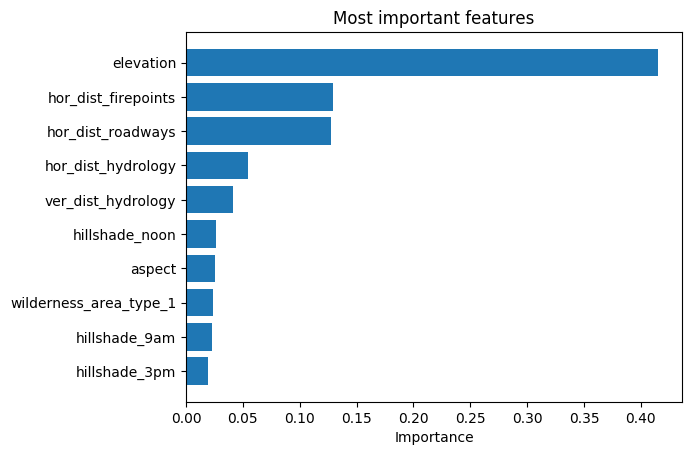

In [29]:
importances, indices, std = top_features(decision_tree)

plot_importance(importances, indices, std)

## Random Forest

A random forest can be seen as a large number of trees with a single, aggregated result (averages for regression or 'majority rule' for classification). Random forests aim to reduce the variance seen in decision trees through:

1.   Training on different samples (called [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating))
2.   Randomly subsetting features (They are random forests after all)
3.   Building and combining small trees

`CRITERION` is as described above, `N_ESTIMATORS` is the number of trees used to build the forest. `MAX_DEPTH` is the max depth of each tree in the forest.

Note: A high `N_ESTIMATORS` and `MAX_DEPTH` will result in a long training time and large memory requirements.

Our random forest is provided by sklearns's `sklearn.ensemble.RandomForestClassifier` class.

In [0]:
CRITERION = 'entropy'
N_ESTIMATORS = 200 # Number of trees in our forest
MAX_DEPTH = None

forest = RandomForestClassifier(n_estimators = N_ESTIMATORS, 
                                criterion = CRITERION, max_depth = MAX_DEPTH, 
                                random_state = 1)

In [0]:
time_start = time.time()

forest.fit(x_train, y_train)

time_end = time.time()

In [32]:
print('Random forest test accuracy: {}%'.format(round2(forest.score(x_test, y_test))))
print('Time elapsed: {0:.2f} seconds'.format(time_end-time_start))

Random forest test accuracy: 95.75%
Time elapsed: 244.73 seconds


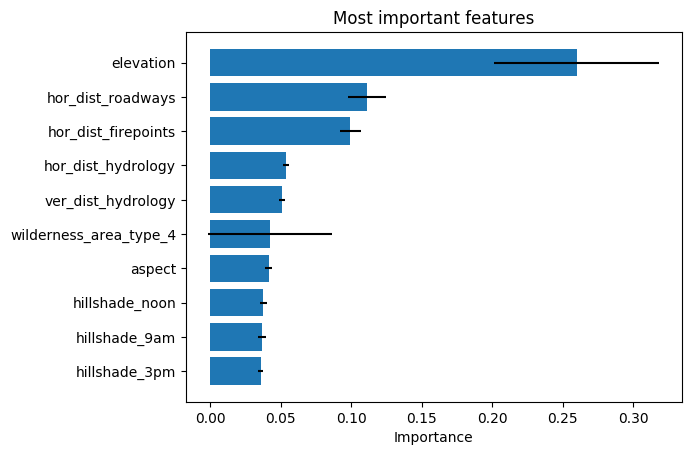

In [33]:
importances, indices, std = top_features(forest)

plot_importance(importances, indices, std)

## Gradient boosted tree (xgboost)

Similar to random forests, gradient boosted trees are a set of decision tree with a key difference: Random forests build each tree independently, whilst gradient boosting builds them sequentially, in an additive manner, such that each new tree improves on the weaknesses of the existing trees. The aggregation of results is done in using a weighting, controlled by `LEARN_RATE`.


`N_ESTIMATORS` - number of boosting rounds to perform.

`MAX_DEPTH` - maximum depth of tree.

`SUBSAMPLE` - percentage of rows randomly taken to build the tree, subsampling occurs every boost iteration.

`COLSAMPLE_BYTREE` - percentage of columns used by each tree. This prevents certain columns from dominating the prediction. 

`GAMMA` - acts as a form of regularization. Either 0, 1 or 5 usually.

Our gradient boosted tree is provided by the `xgboost` framework which has demonstrated [competitive performance in Kaggle competitions](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions).


In [0]:
LEARN_RATE = 0.01
# Number of boosting rounds, can be fine tuned nicely using the eval_set and 
# eval_metric parameters which show the current loss after each boosting round
N_ESTIMATORS = 1000
MAX_DEPTH = 12
SUBSAMPLE = 0.8
COLSAMPLE_BYTREE = 1
GAMMA = 1

# tree_method set for performance
# set objective function to multiclass softmax and indicate we have 7 classes 
boosted_tree = XGBClassifier(learn_rate = LEARN_RATE, n_estimators = N_ESTIMATORS,
                             max_depth = MAX_DEPTH, subsample = SUBSAMPLE,
                             colsample_bytree = 1, gamma = 1, 
                             objective='multi:softmax', num_class=7,
                             tree_method = 'gpu_hist', random_state=1)

In [0]:
time_start = time.time()

boosted_tree.fit(x_train, y_train)

time_end = time.time()

In [52]:
print('Boosted tree test accuracy: {}%'.format(round2(boosted_tree.score(x_test, y_test))))
print('Time elapsed: {0:.2f} seconds'.format(time_end-time_start))

Boosted tree test accuracy: 97.37%
Time elapsed: 320.10 seconds


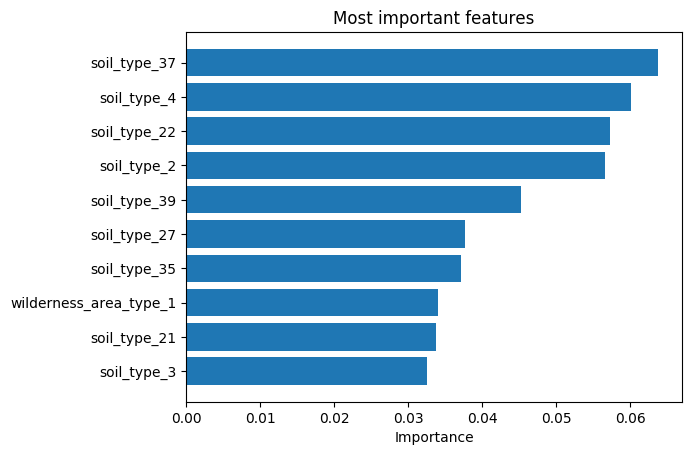

In [53]:
importances, indices, std = top_features(boosted_tree)

plot_importance(importances, indices, std)

## Discussion

### Results

From the above we can see the boosted tree perfomed the best, followed by the random forest and then (as expected) the decision tree. 

### Fine-tuning

Whilst the xgboost model resulted in the top performance, it requires a lot more fine tuning compared to random forest. To demonstrate this, we rerun the training and testing using the default values for each model.



In [0]:
def_forest = RandomForestClassifier(random_state = 1)
def_xgb = XGBClassifier(random_state = 1)

In [49]:
def_forest.fit(x_train, y_train)
def_xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [50]:
print('Default random forest test accuracy: {}'.format(np.round(def_forest.score(x_test, y_test)*100, 2)))
print('Default xgb test accuracy: {}'.format(np.round(def_xgb.score(x_test, y_test)*100, 2)))


Default random forest test accuracy: 95.48
Default xgb test accuracy: 74.32


This results in a whopping 21.16% difference in testing accuracies. So whilst xgboost is the more sophisticated approach, it does require more fine tuning.

### Usage

Random forests are less prone to overfit in comparision to gradient boosted models, especially when the data is noisy.

Random forests have been found to perform well with noisy data, such as in the domain of [bioinformatics](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2648734/?source=post_page---------------------------) or multi-class object detection. Whilst gradient boosting is well-suited for handling unbalanced data, such as in [risk assessment](https://www.academia.edu/7707785/Application_of_Stochastic_Gradient_Boosting_SGB_Technique_to_Enhance_the_Reliability_of_Real-Time_Risk_Assessment_Using_AVI_and_RTMS_Data) or anomaly detection.

Further, gradient boosted models will work with **ANY** differentiable cost function (you can even define your own!). 

This was a classification problem, but we can use the above for regression tasks as well, each class conveniently comes with a regression variant: `sklearn.tree.DecisionTreeRegressor`, `sklearn.ensemble.RandomForestRegressor`, `xgboost.XGBRegressor`.